In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import multiprocessing
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings('ignore')
cores = multiprocessing.cpu_count()
os.listdir()

['opencv-text-detection.zip',
 '.ipynb_checkpoints',
 'accepted_projects',
 'Andrew W. Trask - Grokking Deep Learning-Manning Publications (2019).pdf',
 'Collective_Dataset',
 'corpus',
 'corpus.zip',
 'doc2vec.ipynb',
 'doc2vec_with_kfold.html',
 'doc2vec_with_kfold.ipynb',
 'Final Slides and Books',
 'google-play-store-apps',
 'google-play-store-apps.zip',
 'helpline-of-all-sorts',
 'helpline-of-all-sorts.zip',
 'kmeans_clustering.html',
 'kmeans_clustering.ipynb',
 'labels.txt',
 'logistic_regression.ipynb',
 'MURA-v1.1',
 'MURA-v1.1.zip',
 'nltk',
 'opencv-text-detection',
 'Papers',
 'Papers.zip',
 'Papers_Association_Rule',
 'processed_dataset.csv',
 'Results',
 'reviews.txt',
 'sentiment_analysis_from_story_preprocessing.html',
 'sentiment_analysis_from_story_preprocessing.ipynb',
 'sentiment_dictionary.csv',
 'sklearn_test.ipynb',
 'Slides',
 'Story-categorization-using-NLP',
 'Tan.pdf',
 'Testing',
 'Udacity',
 'videodata.csv',
 'word2vec.model',
 'word2vector_test.ipynb']

In [2]:
df = pd.read_csv(os.getcwd() + "/Collective_Dataset/419_data - Sheet1.csv", usecols=[0,1])#header=None, , names=['story', 'category']

In [3]:
df.head(10)

,story,category
0,"Just like any other day, employees arrived in ...",0
1,My so-called ‘friends’ in middle school used t...,1
2,i have been called hurtful names and i have be...,1
3,at my old school kids would hit me and call me...,1
4,I had debilitating migraines for three years b...,0
5,"I love my work, but hate going each day becaus...",0
6,I have a chronic illness which was doing well ...,0
7,The other part is that sense of worthlessness....,0
8,I feel my whole body hurting. My mental health...,0
9,"As a librarian, I've been threatened with stal...",2


In [4]:
df['story']

0      Just like any other day, employees arrived in ...
1      My so-called ‘friends’ in middle school used t...
2      i have been called hurtful names and i have be...
3      at my old school kids would hit me and call me...
4      I had debilitating migraines for three years b...
                             ...                        
254    My stress strikes when I find out that I am th...
255    I went back to college last year. I am nearly ...
256    The stress got me. I completely mentally check...
257    I’ve recently come out of hospital myself afte...
258    Today morning, me and my cousin were going to ...
Name: story, Length: 259, dtype: object

In [5]:
df['category']

0      0
1      1
2      1
3      1
4      0
      ..
254    0
255    0
256    0
257    0
258    2
Name: category, Length: 259, dtype: int64

In [7]:
df.shape

(259, 2)

In [8]:
df.index = range(259)

In [9]:
df.story.apply(lambda x: len(x.split(' '))).sum()

48315

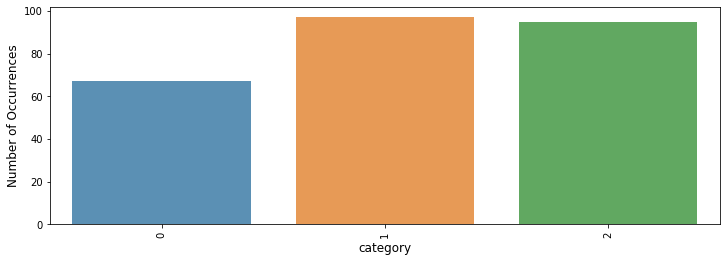

In [10]:
cnt_pro = df['category'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [11]:
work_stress_counter, bullying_counter, sexual_harassment_counter = 0, 0, 0
for c in df['category']:
    if c==0:
        work_stress_counter+=1
    elif c == 1:
        bullying_counter+=1
    else:
        sexual_harassment_counter+=1
print("Work Stress Total Data Count: ", work_stress_counter)
print("Bullying Total Data Count: ", bullying_counter)
print("Sexual Harassment Total Data Count: ", sexual_harassment_counter)

Work Stress Total Data Count:  67
Bullying Total Data Count:  97
Sexual Harassment Total Data Count:  95


In [12]:
print(df.story[2])
print(df.category[2])

i have been called hurtful names and i have been called black bitch and people are making fun of me for being black by my suppost to be friend t and she has posted rumors about me and i dont know what to do.
1


In [13]:
print(df.story[0])
print(df.category[0])

Just like any other day, employees arrived in the workplace sparingly, filling the cubicles and getting their coffees ready. Once more, the manager was already sitting at his desk, grumbling and shouting - You’re way too slow, again! How am I supposed to get my work done with you slowing me down every day? The other employees were staring at each other. They were embarrassed by his outburst but deep inside they knew he was right. Satisfied by the nods in the assembly, the manager calmed down. As usual, he quickly got absorbed by his screen and numerous emails. He was not the moody type, just a normal guy. His team liked him very much and his performance record was exemplary. He was often described as someone caring and trustworthy with a genuine interest in people. Yet once again, his fist hit the desk loudly as he started screaming. That’s it, I’m done! Slow and unreliable old crap! You made me lose five hours of my life, again. World will be better off without you and I’m going to le

In [14]:
print(df.story[10])
print(df.category[10])

I worked as an office manager, and the only woman, for an industrial insulation company. I had just come back from maternity leave and I was worried about my milk supply. I went into the bathroom to pump for about 15 minutes every two hours, and all of the men in the office would stand in the break area (right in front of the bathroom door) and make baby crying noises to make fun of me. Eventually it progressed to the point that they would make crying noises every time they passed my desk in hopes that I would leak through my shirt. They would also make comments about how much larger my breasts were since having a baby. I felt so harassed and unsafe that I would dread going to work every day, and I even had more than a few nervous breakdowns. My husband was furious and I had to convince him not to take any drastic action so that I could be sure to have a good reference if I needed to find another job. We had a long conversation and looked at our finances and decided the extra money was

In [15]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['story'] = df['story'].apply(cleanText)

In [16]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

### WITH TRAIN_TEST_SPLIT

In [17]:
train, test = train_test_split(df, test_size = .20, random_state = 2)

In [18]:
train_tagged = train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)

In [19]:
train

,story,category
197,i had been seeing this guy for just over three...,2
201,i noticed movement out of the corner of my eye...,2
94,"i'm 13 years old and live in nsw, australia wi...",1
25,"my bullying started, or when i first noticed i...",1
85,my story might be short because i only remembe...,1
...,...,...
43,i was on my way from gabtoli to mirpur on a bu...,2
22,"hi, i'm rahul. i was bullied all through schoo...",1
72,"when i was in 7th grade, i had a semester of m...",1
15,"i got made fun of for being fat in elementary,...",1


In [20]:
len(train)

207

In [21]:
test

,story,category
30,a girl jumped on me on my friend's house! she ...,2
244,with that 22 years of service — including four...,0
140,"i loved my work, but hated going each day beca...",0
10,"i worked as an office manager, and the only wo...",2
181,"this one time, a man came in with his son. whe...",2
160,"when i was 77, i was at a brunch and man came ...",2
192,my trainer facetimed me multiple times. i igno...,2
35,"when i got admitted in a well reputed college,...",1
101,"hello! first of all, i'm sorry if there are a ...",1
13,i work in law enforcement. i started out as a ...,2


In [22]:
len(test)

52

In [23]:
train_tagged

197    ([had, been, seeing, this, guy, for, just, ove...
201    ([noticed, movement, out, of, the, corner, of,...
94     (['m, 13, years, old, and, live, in, nsw, aust...
25     ([my, bullying, started, or, when, first, noti...
85     ([my, story, might, be, short, because, only, ...
                             ...                        
43     ([was, on, my, way, from, gabtoli, to, mirpur,...
22     ([hi, 'm, rahul, was, bullied, all, through, s...
72     ([when, was, in, 7th, grade, had, semester, of...
15     ([got, made, fun, of, for, being, fat, in, ele...
168    ([let, me, tell, you, about, few, of, my, eper...
Length: 207, dtype: object

In [24]:
train_tagged.values[2]

TaggedDocument(words=["'m", '13', 'years', 'old', 'and', 'live', 'in', 'nsw', 'australia', 'with', 'my', 'mum', 'brother', 'sister', 'and', 'dad', 'was', 'first', 'bullied', 'in', 'year', 'after', 'recently', 'transferring', 'from', 'private', 'school', 'to', 'public', 'school', 'was', 'very', 'shy', 'back', 'then', 'and', 'therefore', 'did', 'not', 'make', 'friends', 'easily', 'as', 'we', 'lived', 'on', 'farm', 'had', 'to', 'catch', 'bus', 'home', 'every', 'afternoon', 'with', 'bunch', 'of', 'cruel', 'dirty', 'seniors', 'who', 'constantly', 'pushed', 'and', 'shoved', 'me', 'around', 'there', 'was', 'this', 'one', 'girl', 'cody', 'who', 'used', 'to', 'call', 'me', 'names', 'all', 'the', 'time', 'some', 'better', 'than', 'others', 'and', 'would', 'slap', 'me', 'around', 'whenever', 'tried', 'to', 'tell', 'the', 'teacher', 'it', 'stopped', 'after', 'she', 'left', 'and', 'soon', 'began', 'to', 'make', 'friends', 'and', 'enjoy', 'school', 'well', 'you', 'ca', "n't", 'say', "'enjoy", 'more'

In [25]:
test_tagged.values[1]

TaggedDocument(words=['with', 'that', '22', 'years', 'of', 'service', 'including', 'four', 'overseas', 'deployments', 'rwanda', 'and', 'afghanistan', 'number', 'of', 'in-canada', 'deployments', 'manitoba', 'flood', 'quebec', 'ice', 'storm', 'training', 'searches', 'for', 'missing', 'persons', 'two', 'marriage', 'breakdowns', 'and', 'number', 'of', 'injuries', 'comes', 'barrack', 'bo', 'full', 'of', 'mental', 'issues', 'that', 'need', 'to', 'be', 'resolved', 'found', 'myself', 'reaching', 'the', 'point', 'where', 'my', 'psychological', 'issues', 'were', 'ruining', 'my', 'life', 'my', 'relationships', 'and', 'my', 'work', 'and', 'felt', 'need', 'to', 'break', 'free', 'of', 'the', 'military', 'stigma', 'about', 'discussing', 'one', "'s", 'mental', 'problems', 'so', 'one', 'day', 'walked', 'into', 'the', 'warrior', 'support', 'centre', 'in', 'petawawa', 'and', 'asked', 'for', 'help', 'spilling', 'your', 'guts', 'to', 'stranger', 'is', 'not', 'an', 'easy', 'task', 'perhaps', 'especially', '

### PV-DBOW

In [26]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 207/207 [00:00<00:00, 888660.11it/s]


In [27]:
%%time
for epoch in range(5):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 207/207 [00:00<00:00, 815997.11it/s]

CPU times: user 371 ms, sys: 9.69 ms, total: 381 ms
Wall time: 135 ms


In [28]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [29]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [30]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [31]:
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
print('\nTesting Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred),"\n")
print('Testing Classification Report: ')
print(classification_report(y_test, y_pred))

Testing accuracy 0.8269230769230769
Testing F1 score: 0.8204652490366775

Testing Confusion Matrix: 
[[ 8  2  2]
 [ 0 22  0]
 [ 2  3 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.81      1.00      0.90        22
           2       0.87      0.72      0.79        18

    accuracy                           0.83        52
   macro avg       0.83      0.80      0.80        52
weighted avg       0.83      0.83      0.82        52



### PV-DM

In [32]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 207/207 [00:00<00:00, 1273051.21it/s]


In [33]:
%%time
for epoch in range(5):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 207/207 [00:00<00:00, 1129025.91it/s]

CPU times: user 450 ms, sys: 17.9 ms, total: 468 ms
Wall time: 193 ms


In [34]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)

In [35]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [36]:
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
print('\nTesting Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred),"\n")
print('Testing Classification Report: ')
print(classification_report(y_test, y_pred))

Testing accuracy 0.8269230769230769
Testing F1 score: 0.8251719041192727

Testing Confusion Matrix: 
[[ 8  1  3]
 [ 0 20  2]
 [ 1  2 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.87      0.91      0.89        22
           2       0.75      0.83      0.79        18

    accuracy                           0.83        52
   macro avg       0.84      0.80      0.81        52
weighted avg       0.83      0.83      0.83        52



### Paired Model

In [37]:
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [38]:
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [39]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [40]:
y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)

In [41]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [42]:
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
print('\nTesting Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred),"\n")
print('Testing Classification Report: ')
print(classification_report(y_test, y_pred))

Testing accuracy 0.7884615384615384
Testing F1 score: 0.785570950788342

Testing Confusion Matrix: 
[[ 8  1  3]
 [ 1 20  1]
 [ 2  3 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        12
           1       0.83      0.91      0.87        22
           2       0.76      0.72      0.74        18

    accuracy                           0.79        52
   macro avg       0.78      0.77      0.77        52
weighted avg       0.79      0.79      0.79        52



### WITH K-FOLD

In [43]:
X = df['story']
print("Length: ", len(X))
print("Type: ", type(X))
print("First Ten Values:\n", X[:10])
print(X[0])

Length:  259
Type:  <class 'pandas.core.series.Series'>
First Ten Values:
 0    just like any other day, employees arrived in ...
1    my so-called ‘friends’ in middle school used t...
2    i have been called hurtful names and i have be...
3    at my old school kids would hit me and call me...
4    i had debilitating migraines for three years b...
5    i love my work, but hate going each day becaus...
6    i have a chronic illness which was doing well ...
7    the other part is that sense of worthlessness....
8    i feel my whole body hurting. my mental health...
9    as a librarian, i've been threatened with stal...
Name: story, dtype: object
just like any other day, employees arrived in the workplace sparingly, filling the cubicles and getting their coffees ready. once more, the manager was already sitting at his desk, grumbling and shouting - you’re way too slow, again! how am i supposed to get my work done with you slowing me down every day? the other employees were staring at each

In [44]:
y = df['category']
print("Length: ", len(y))
print("Type: ", type(y))
print("First Ten Values: ", y[:10])

Length:  259
Type:  <class 'pandas.core.series.Series'>
First Ten Values:  0    0
1    1
2    1
3    1
4    0
5    0
6    0
7    0
8    0
9    2
Name: category, dtype: int64


In [45]:
ten_fold = KFold(n_splits=5, shuffle = True, random_state=42)
ten_fold

KFold(n_splits=5, random_state=42, shuffle=True)

In [46]:
print("Total Fold: ", ten_fold.get_n_splits(X))
fold_no = 1
for train_index, test_index in ten_fold.split(X):
#     print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("X_train: ", X_train.shape, "X_test: ", X_test.shape)

Total Fold:  5
X_train:  (207,) X_test:  (52,)
X_train:  (207,) X_test:  (52,)
X_train:  (207,) X_test:  (52,)
X_train:  (207,) X_test:  (52,)
X_train:  (208,) X_test:  (51,)


In [47]:
total_fold = ten_fold.get_n_splits(X)
print(total_fold)

5


### K-FOLD PV-DBOW

In [48]:
print("Total Fold: ", total_fold)
fold_no = 1
for train_index, test_index in ten_fold.split(X):
    print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("No. of Training Dataset in Fold: ", fold_no, "", len(X_train))
    print("No. of Testing Dataset in Fold: ", fold_no, "", len(X_test))
    
    X_train = list(zip(X_train,y_train))
    X_train = pd.DataFrame(X_train, columns=['story', 'category'])
    
    X_test = list(zip(X_test,y_test))
    X_test = pd.DataFrame(X_test, columns=['story', 'category'])
    
    train_tagged = X_train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    test_tagged = X_test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
    model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha
    
    def vec_for_learning(model, tagged_docs):
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
        return targets, regressors
    
    y_trained, X_trained = vec_for_learning(model_dbow, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dbow, test_tagged)
    
    logreg = LogisticRegression(n_jobs=1, C=1e5)
    logreg.fit(X_trained, y_trained)
    y_pred = logreg.predict(X_tested)
    
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))
    
    print("\n\n")
    fold_no+=1

Total Fold:  5
Train Fold No.:  [  0   1   2   3   4   5   7   8  11  12  13  14  17  20  21  22  23  26
  27  28  29  31  32  34  35  36  37  38  39  40  41  42  43  44  47  48
  49  50  51  52  53  54  56  57  58  59  61  62  63  64  65  69  70  71
  72  74  76  77  78  79  80  81  82  83  85  86  87  88  89  91  93  94
  95  96  97  98  99 100 102 103 105 106 107 110 111 112 113 114 115 116
 117 118 120 121 122 123 124 126 127 128 129 130 131 133 134 135 136 138
 139 140 141 142 144 145 146 147 149 150 151 153 154 155 156 157 158 159
 160 161 162 163 164 166 167 169 170 171 172 173 174 175 177 179 181 182
 183 186 187 188 189 191 192 193 194 195 196 197 198 199 201 202 203 204
 207 208 209 210 211 213 214 215 216 217 218 219 220 221 222 223 224 225
 226 228 230 231 232 233 234 235 236 238 239 240 242 243 244 245 246 247
 248 249 251 252 253 254 255 256 258]  Test Fold No.:  [  6   9  10  15  16  18  19  24  25  30  33  45  46  55  60  66  67  68
  73  75  84  90  92 101 104 108 109 

100%|██████████| 207/207 [00:00<00:00, 1256470.23it/s]


Fold No.:  1
Testing accuracy 0.8653846153846154
Testing F1 score: 0.8651988108509848

Testing Confusion Matrix: 
[[10  1  1]
 [ 0 20  2]
 [ 1  2 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        12
           1       0.87      0.91      0.89        22
           2       0.83      0.83      0.83        18

    accuracy                           0.87        52
   macro avg       0.87      0.86      0.86        52
weighted avg       0.87      0.87      0.87        52




Train Fold No.:  [  0   1   3   4   6   7   8   9  10  11  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  30  32  33  34  36  37  39  40  41  43  44
  45  46  47  48  49  50  51  52  53  54  55  57  58  59  60  61  62  63
  64  66  67  68  70  71  72  73  74  75  76  78  80  81  83  84  87  88
  89  90  91  92  93  94  95  98  99 100 101 102 103 104 105 106 107 108
 109 110 112 113 114 116 118 119 120 121 122 123 

100%|██████████| 207/207 [00:00<00:00, 168684.85it/s]


Fold No.:  2
Testing accuracy 0.8846153846153846
Testing F1 score: 0.8843640020110608

Testing Confusion Matrix: 
[[16  0  0]
 [ 2 15  1]
 [ 2  1 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        16
           1       0.94      0.83      0.88        18
           2       0.94      0.83      0.88        18

    accuracy                           0.88        52
   macro avg       0.89      0.89      0.88        52
weighted avg       0.90      0.88      0.88        52




Train Fold No.:  [  1   2   3   5   6   7   8   9  10  12  13  14  15  16  17  18  19  20
  21  23  24  25  28  29  30  31  33  34  35  37  38  39  40  42  43  44
  45  46  47  48  49  50  52  53  54  55  56  57  58  59  60  63  64  65
  66  67  68  69  71  72  73  74  75  77  79  80  81  82  83  84  85  86
  87  88  89  90  91  92  94  96  97  99 101 102 103 104 105 106 107 108
 109 110 111 115 116 117 119 121 123 125 126 129 

100%|██████████| 207/207 [00:00<00:00, 709910.82it/s]


Fold No.:  3
Testing accuracy 0.8653846153846154
Testing F1 score: 0.8663230977060764

Testing Confusion Matrix: 
[[ 8  0  3]
 [ 0 17  2]
 [ 2  0 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       1.00      0.89      0.94        19
           2       0.80      0.91      0.85        22

    accuracy                           0.87        52
   macro avg       0.87      0.84      0.85        52
weighted avg       0.87      0.87      0.87        52




Train Fold No.:  [  0   1   2   4   5   6   9  10  11  12  14  15  16  18  19  20  21  22
  24  25  26  27  28  29  30  31  32  33  35  36  37  38  41  42  45  46
  48  50  51  52  54  55  56  57  58  60  61  62  63  65  66  67  68  69
  70  71  73  74  75  76  77  78  79  82  84  85  86  87  88  90  92  93
  95  96  97  98  99 100 101 102 103 104 106 107 108 109 111 112 113 114
 115 116 117 118 119 120 121 122 124 125 126 127 

100%|██████████| 207/207 [00:00<00:00, 729597.42it/s]


Fold No.:  4
Testing accuracy 0.9038461538461539
Testing F1 score: 0.9036552777247567

Testing Confusion Matrix: 
[[14  1  1]
 [ 1 15  1]
 [ 0  1 18]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.88      0.90        16
           1       0.88      0.88      0.88        17
           2       0.90      0.95      0.92        19

    accuracy                           0.90        52
   macro avg       0.91      0.90      0.90        52
weighted avg       0.90      0.90      0.90        52




Train Fold No.:  [  0   2   3   4   5   6   7   8   9  10  11  12  13  15  16  17  18  19
  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  38  39  40
  41  42  43  44  45  46  47  49  51  53  55  56  59  60  61  62  64  65
  66  67  68  69  70  72  73  75  76  77  78  79  80  81  82  83  84  85
  86  89  90  91  92  93  94  95  96  97  98 100 101 104 105 108 109 110
 111 112 113 114 115 117 118 119 120 122 123 124 

100%|██████████| 208/208 [00:00<00:00, 904995.05it/s]


Fold No.:  5
Testing accuracy 0.8235294117647058
Testing F1 score: 0.8218056453350571

Testing Confusion Matrix: 
[[ 8  2  2]
 [ 0 18  3]
 [ 1  1 16]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.86      0.86      0.86        21
           2       0.76      0.89      0.82        18

    accuracy                           0.82        51
   macro avg       0.84      0.80      0.81        51
weighted avg       0.83      0.82      0.82        51






### K-FOLD PV-DM 

In [49]:
fold_no = 1
print("Total Fold: ", total_fold)
for train_index, test_index in ten_fold.split(X):
#     print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("No. of Training Dataset in Fold ", fold_no, ": ", len(X_train))
    print("No. of Testing Dataset in Fold ", fold_no, ": ", len(X_test))
    
    X_train = list(zip(X_train,y_train))
    X_train = pd.DataFrame(X_train, columns=['story', 'category'])
    
    X_test = list(zip(X_test,y_test))
    X_test = pd.DataFrame(X_test, columns=['story', 'category'])
    
    train_tagged = X_train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    test_tagged = X_test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    
    model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
    model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dmm.alpha -= 0.002
        model_dmm.min_alpha = model_dmm.alpha
    
    def vec_for_learning(model, tagged_docs):
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
        return targets, regressors
    
    y_trained, X_trained = vec_for_learning(model_dmm, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dmm, test_tagged)
    
    logreg = LogisticRegression(n_jobs=1, C=1e5)
    logreg.fit(X_trained, y_trained)
    y_pred = logreg.predict(X_tested)
    
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))
    print("\n\n")
    fold_no+=1

Total Fold:  5
No. of Training Dataset in Fold  1 :  207
No. of Testing Dataset in Fold  1 :  52


100%|██████████| 207/207 [00:00<00:00, 679359.10it/s]


Fold No.:  1
Testing accuracy 0.8461538461538461
Testing F1 score: 0.845484949832776

Testing Confusion Matrix: 
[[10  1  1]
 [ 0 20  2]
 [ 1  3 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        12
           1       0.83      0.91      0.87        22
           2       0.82      0.78      0.80        18

    accuracy                           0.85        52
   macro avg       0.86      0.84      0.85        52
weighted avg       0.85      0.85      0.85        52




No. of Training Dataset in Fold  2 :  207
No. of Testing Dataset in Fold  2 :  52


100%|██████████| 207/207 [00:00<00:00, 716945.44it/s]


Fold No.:  2
Testing accuracy 0.9230769230769231
Testing F1 score: 0.9223653929536282

Testing Confusion Matrix: 
[[16  0  0]
 [ 1 15  2]
 [ 1  0 17]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        16
           1       1.00      0.83      0.91        18
           2       0.89      0.94      0.92        18

    accuracy                           0.92        52
   macro avg       0.93      0.93      0.92        52
weighted avg       0.93      0.92      0.92        52




No. of Training Dataset in Fold  3 :  207
No. of Testing Dataset in Fold  3 :  52


100%|██████████| 207/207 [00:00<00:00, 769017.65it/s]


Fold No.:  3
Testing accuracy 0.8076923076923077
Testing F1 score: 0.8063359345968042

Testing Confusion Matrix: 
[[ 7  2  2]
 [ 0 16  3]
 [ 0  3 19]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.64      0.78        11
           1       0.76      0.84      0.80        19
           2       0.79      0.86      0.83        22

    accuracy                           0.81        52
   macro avg       0.85      0.78      0.80        52
weighted avg       0.82      0.81      0.81        52




No. of Training Dataset in Fold  4 :  207
No. of Testing Dataset in Fold  4 :  52


100%|██████████| 207/207 [00:00<00:00, 1536674.21it/s]


Fold No.:  4
Testing accuracy 0.8846153846153846
Testing F1 score: 0.884032634032634

Testing Confusion Matrix: 
[[15  0  1]
 [ 2 14  1]
 [ 0  2 17]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        16
           1       0.88      0.82      0.85        17
           2       0.89      0.89      0.89        19

    accuracy                           0.88        52
   macro avg       0.88      0.89      0.88        52
weighted avg       0.88      0.88      0.88        52




No. of Training Dataset in Fold  5 :  208
No. of Testing Dataset in Fold  5 :  51


100%|██████████| 208/208 [00:00<00:00, 759282.19it/s]


Fold No.:  5
Testing accuracy 0.803921568627451
Testing F1 score: 0.79484484124127

Testing Confusion Matrix: 
[[ 6  2  4]
 [ 0 19  2]
 [ 1  1 16]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.50      0.63        12
           1       0.86      0.90      0.88        21
           2       0.73      0.89      0.80        18

    accuracy                           0.80        51
   macro avg       0.82      0.76      0.77        51
weighted avg       0.81      0.80      0.79        51






### PAIRED MODEL

In [50]:
fold_no = 1
print("Total Fold No.: {}\n\n" .format(total_fold))
for train_index, test_index in ten_fold.split(X):
#     print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("No. of Training Dataset in Fold ", fold_no, ": ", len(X_train))
    print("No. of Testing Dataset in Fold ", fold_no, ": ", len(X_test))
    
    X_train = list(zip(X_train,y_train))
    X_train = pd.DataFrame(X_train, columns=['story', 'category'])
    
    X_test = list(zip(X_test,y_test))
    X_test = pd.DataFrame(X_test, columns=['story', 'category'])
    
    train_tagged = X_train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    test_tagged = X_test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    
    #PV_DBOW
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
    model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha
    
    def vec_for_learning(model, tagged_docs):
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
        return targets, regressors
    
    y_trained, X_trained = vec_for_learning(model_dbow, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dbow, test_tagged)
    
    logreg_dbow = LogisticRegression(n_jobs=1, C=1e5)
    logreg_dbow.fit(X_trained, y_trained)
    y_pred = logreg_dbow.predict(X_tested)
    
    print("FOR PV_DBOW: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    
    #PV_DM
    model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
    model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dmm.alpha -= 0.002
        model_dmm.min_alpha = model_dmm.alpha
    
    y_trained, X_trained = vec_for_learning(model_dmm, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dmm, test_tagged)
    
    logreg_dm = LogisticRegression(n_jobs=1, C=1e5)
    logreg_dm.fit(X_trained, y_trained)
    y_pred = logreg_dm.predict(X_tested)
    
    print("FOR PV_DM: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    #FOR PAIRED_MODEL
    model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    
    new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])
    
    y_train, X_train = vec_for_learning(new_model, train_tagged)
    y_test, X_test = vec_for_learning(new_model, test_tagged)
    
    logreg_paired = LogisticRegression(n_jobs=1, C=1e5)
    logreg_paired.fit(X_train, y_train)
    y_pred = logreg_paired.predict(X_test)
    
    print("FOR Paired Model: ")
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))
    fold_no+=1

Total Fold No.: 5


No. of Training Dataset in Fold  1 :  207
No. of Testing Dataset in Fold  1 :  52


100%|██████████| 207/207 [00:00<00:00, 885036.62it/s]

FOR PV_DBOW: 
Fold No.:  1
Testing accuracy 0.8653846153846154
Testing F1 score: 0.8640827257848535

Testing Confusion Matrix: 
[[10  2  0]
 [ 0 21  1]
 [ 2  2 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        12
           1       0.84      0.95      0.89        22
           2       0.93      0.78      0.85        18

    accuracy                           0.87        52
   macro avg       0.87      0.86      0.86        52
weighted avg       0.87      0.87      0.86        52







100%|██████████| 207/207 [00:00<00:00, 793620.59it/s]


FOR PV_DM: 
Fold No.:  1
Testing accuracy 0.8653846153846154
Testing F1 score: 0.8624009857419469

Testing Confusion Matrix: 
[[ 8  1  3]
 [ 0 21  1]
 [ 0  2 16]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        12
           1       0.88      0.95      0.91        22
           2       0.80      0.89      0.84        18

    accuracy                           0.87        52
   macro avg       0.89      0.84      0.85        52
weighted avg       0.88      0.87      0.86        52




FOR Paired Model: 
Testing accuracy 0.8269230769230769
Testing F1 score: 0.8231236848258126

Testing Confusion Matrix: 
[[ 8  1  3]
 [ 0 21  1]
 [ 1  3 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.84      0.95      0.89        22
           2       0.78      0.78      0.78        18

    accura

100%|██████████| 207/207 [00:00<00:00, 643603.36it/s]

FOR PV_DBOW: 
Fold No.:  2
Testing accuracy 0.9230769230769231
Testing F1 score: 0.922927072927073

Testing Confusion Matrix: 
[[16  0  0]
 [ 1 17  0]
 [ 2  1 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        16
           1       0.94      0.94      0.94        18
           2       1.00      0.83      0.91        18

    accuracy                           0.92        52
   macro avg       0.93      0.93      0.92        52
weighted avg       0.93      0.92      0.92        52







100%|██████████| 207/207 [00:00<00:00, 690159.72it/s]


FOR PV_DM: 
Fold No.:  2
Testing accuracy 0.9423076923076923
Testing F1 score: 0.9423076923076923

Testing Confusion Matrix: 
[[16  0  0]
 [ 1 16  1]
 [ 1  0 17]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        16
           1       1.00      0.89      0.94        18
           2       0.94      0.94      0.94        18

    accuracy                           0.94        52
   macro avg       0.94      0.94      0.94        52
weighted avg       0.95      0.94      0.94        52




FOR Paired Model: 
Testing accuracy 0.8846153846153846
Testing F1 score: 0.884892884892885

Testing Confusion Matrix: 
[[16  0  0]
 [ 1 15  2]
 [ 3  0 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        16
           1       1.00      0.83      0.91        18
           2       0.88      0.83      0.86        18

    accurac

100%|██████████| 207/207 [00:00<00:00, 787144.99it/s]

FOR PV_DBOW: 
Fold No.:  3
Testing accuracy 0.8461538461538461
Testing F1 score: 0.8381410256410255

Testing Confusion Matrix: 
[[ 6  1  4]
 [ 1 17  1]
 [ 0  1 21]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.55      0.67        11
           1       0.89      0.89      0.89        19
           2       0.81      0.95      0.88        22

    accuracy                           0.85        52
   macro avg       0.85      0.80      0.81        52
weighted avg       0.85      0.85      0.84        52







100%|██████████| 207/207 [00:00<00:00, 663777.47it/s]


FOR PV_DM: 
Fold No.:  3
Testing accuracy 0.8461538461538461
Testing F1 score: 0.8423076923076924

Testing Confusion Matrix: 
[[ 7  1  3]
 [ 1 18  0]
 [ 1  2 19]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.86      0.95      0.90        19
           2       0.86      0.86      0.86        22

    accuracy                           0.85        52
   macro avg       0.83      0.82      0.82        52
weighted avg       0.84      0.85      0.84        52




FOR Paired Model: 
Testing accuracy 0.8653846153846154
Testing F1 score: 0.861423405654175

Testing Confusion Matrix: 
[[ 7  1  3]
 [ 1 18  0]
 [ 1  1 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.90      0.95      0.92        19
           2       0.87      0.91      0.89        22

    accurac

100%|██████████| 207/207 [00:00<00:00, 803908.27it/s]

FOR PV_DBOW: 
Fold No.:  4
Testing accuracy 0.9230769230769231
Testing F1 score: 0.9230769230769231

Testing Confusion Matrix: 
[[15  1  0]
 [ 1 15  1]
 [ 0  1 18]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.88      0.88      0.88        17
           2       0.95      0.95      0.95        19

    accuracy                           0.92        52
   macro avg       0.92      0.92      0.92        52
weighted avg       0.92      0.92      0.92        52







100%|██████████| 207/207 [00:00<00:00, 884135.36it/s]


FOR PV_DM: 
Fold No.:  4
Testing accuracy 0.9038461538461539
Testing F1 score: 0.9044401544401544

Testing Confusion Matrix: 
[[15  1  0]
 [ 1 15  1]
 [ 0  2 17]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.83      0.88      0.86        17
           2       0.94      0.89      0.92        19

    accuracy                           0.90        52
   macro avg       0.91      0.90      0.90        52
weighted avg       0.91      0.90      0.90        52




FOR Paired Model: 
Testing accuracy 0.9230769230769231
Testing F1 score: 0.9230769230769231

Testing Confusion Matrix: 
[[15  1  0]
 [ 1 15  1]
 [ 0  1 18]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.88      0.88      0.88        17
           2       0.95      0.95      0.95        19

    accura

100%|██████████| 208/208 [00:00<00:00, 1290555.08it/s]

FOR PV_DBOW: 
Fold No.:  5
Testing accuracy 0.8431372549019608
Testing F1 score: 0.8426681677455671

Testing Confusion Matrix: 
[[ 9  2  1]
 [ 0 18  3]
 [ 1  1 16]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.86      0.86      0.86        21
           2       0.80      0.89      0.84        18

    accuracy                           0.84        51
   macro avg       0.85      0.83      0.84        51
weighted avg       0.85      0.84      0.84        51







100%|██████████| 208/208 [00:00<00:00, 953459.27it/s]


FOR PV_DM: 
Fold No.:  5
Testing accuracy 0.7843137254901961
Testing F1 score: 0.7771977824177406

Testing Confusion Matrix: 
[[ 6  1  5]
 [ 0 19  2]
 [ 1  2 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.50      0.63        12
           1       0.86      0.90      0.88        21
           2       0.68      0.83      0.75        18

    accuracy                           0.78        51
   macro avg       0.80      0.75      0.76        51
weighted avg       0.80      0.78      0.78        51




FOR Paired Model: 
Testing accuracy 0.803921568627451
Testing F1 score: 0.8055270888843342

Testing Confusion Matrix: 
[[ 8  0  4]
 [ 0 18  3]
 [ 1  2 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.90      0.86      0.88        21
           2       0.68      0.83      0.75        18

    accurac

### Decision Tree Using Entropy

In [51]:
fold_no = 1
print("Total Fold No.: {}\n\n" .format(total_fold))
for train_index, test_index in ten_fold.split(X):
#     print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("No. of Training Dataset in Fold ", fold_no, ": ", len(X_train))
    print("No. of Testing Dataset in Fold ", fold_no, ": ", len(X_test))
    
    X_train = list(zip(X_train,y_train))
    X_train = pd.DataFrame(X_train, columns=['story', 'category'])
    
    X_test = list(zip(X_test,y_test))
    X_test = pd.DataFrame(X_test, columns=['story', 'category'])
    
    train_tagged = X_train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    test_tagged = X_test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    
    #PV_DBOW using DT with Entropy
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
    model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha
    
    def vec_for_learning(model, tagged_docs):
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
        return targets, regressors
    
    y_trained, X_trained = vec_for_learning(model_dbow, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dbow, test_tagged)
    
    dt_dbow_entropy = DecisionTreeClassifier(criterion = "entropy", 
                                             random_state = 10, 
                                             max_depth = 3, 
                                             min_samples_leaf = 5)
    dt_dbow_entropy.fit(X_trained, y_trained)
    y_pred = dt_dbow_entropy.predict(X_tested)
    
    print("FOR PV_DBOW Using Decision Tree with Entropy: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    
    #PV_DM
    model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
    model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dmm.alpha -= 0.002
        model_dmm.min_alpha = model_dmm.alpha
    
    y_trained, X_trained = vec_for_learning(model_dmm, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dmm, test_tagged)
    
    dt_dbow_entropy = DecisionTreeClassifier(criterion = "entropy", 
                                             random_state = 10, 
                                             max_depth = 3, 
                                             min_samples_leaf = 5)
    dt_dbow_entropy.fit(X_trained, y_trained)
    y_pred = dt_dbow_entropy.predict(X_tested)
    
    print("FOR PV_DM Using Decision Tree with Entropy:  ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    #FOR PAIRED_MODEL
    model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    
    new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])
    
    y_train, X_train = vec_for_learning(new_model, train_tagged)
    y_test, X_test = vec_for_learning(new_model, test_tagged)
    
    dt_dbow_entropy = DecisionTreeClassifier(criterion = "entropy", 
                                             random_state = 10, 
                                             max_depth = 3, 
                                             min_samples_leaf = 5)
    dt_dbow_entropy.fit(X_trained, y_trained)
    y_pred = dt_dbow_entropy.predict(X_tested)
    
    print("FOR Paired Model Using Decision Tree with Entropy: ")
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))
    fold_no+=1

Total Fold No.: 5


No. of Training Dataset in Fold  1 :  207
No. of Testing Dataset in Fold  1 :  52


100%|██████████| 207/207 [00:00<00:00, 772438.55it/s]

FOR PV_DBOW Using Decision Tree with Entropy: 
Fold No.:  1
Testing accuracy 0.8461538461538461
Testing F1 score: 0.8457516339869281

Testing Confusion Matrix: 
[[10  1  1]
 [ 1 20  1]
 [ 2  2 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        12
           1       0.87      0.91      0.89        22
           2       0.88      0.78      0.82        18

    accuracy                           0.85        52
   macro avg       0.84      0.84      0.84        52
weighted avg       0.85      0.85      0.85        52







100%|██████████| 207/207 [00:00<00:00, 720515.29it/s]


FOR PV_DM Using Decision Tree with Entropy:  
Fold No.:  1
Testing accuracy 0.7692307692307693
Testing F1 score: 0.7669191422388354

Testing Confusion Matrix: 
[[ 9  2  1]
 [ 0 19  3]
 [ 3  3 12]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.79      0.86      0.83        22
           2       0.75      0.67      0.71        18

    accuracy                           0.77        52
   macro avg       0.76      0.76      0.76        52
weighted avg       0.77      0.77      0.77        52




FOR Paired Model Using Decision Tree with Entropy: 
Testing accuracy 0.7692307692307693
Testing F1 score: 0.7669191422388354

Testing Confusion Matrix: 
[[ 9  2  1]
 [ 0 19  3]
 [ 3  3 12]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.79      0.86      0.83        2

100%|██████████| 207/207 [00:00<00:00, 1205862.40it/s]

FOR PV_DBOW Using Decision Tree with Entropy: 
Fold No.:  2
Testing accuracy 0.9038461538461539
Testing F1 score: 0.9048884343001989

Testing Confusion Matrix: 
[[15  0  1]
 [ 0 16  2]
 [ 2  0 16]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        16
           1       1.00      0.89      0.94        18
           2       0.84      0.89      0.86        18

    accuracy                           0.90        52
   macro avg       0.91      0.91      0.91        52
weighted avg       0.91      0.90      0.90        52







100%|██████████| 207/207 [00:00<00:00, 853707.89it/s]


FOR PV_DM Using Decision Tree with Entropy:  
Fold No.:  2
Testing accuracy 0.8653846153846154
Testing F1 score: 0.8663273001508295

Testing Confusion Matrix: 
[[13  3  0]
 [ 0 17  1]
 [ 1  2 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.81      0.87        16
           1       0.77      0.94      0.85        18
           2       0.94      0.83      0.88        18

    accuracy                           0.87        52
   macro avg       0.88      0.86      0.87        52
weighted avg       0.88      0.87      0.87        52




FOR Paired Model Using Decision Tree with Entropy: 
Testing accuracy 0.8653846153846154
Testing F1 score: 0.8663273001508295

Testing Confusion Matrix: 
[[13  3  0]
 [ 0 17  1]
 [ 1  2 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.81      0.87        16
           1       0.77      0.94      0.85        1

100%|██████████| 207/207 [00:00<00:00, 650352.76it/s]

FOR PV_DBOW Using Decision Tree with Entropy: 
Fold No.:  3
Testing accuracy 0.9038461538461539
Testing F1 score: 0.9038461538461539

Testing Confusion Matrix: 
[[ 9  0  2]
 [ 1 18  0]
 [ 1  1 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.95      0.95      0.95        19
           2       0.91      0.91      0.91        22

    accuracy                           0.90        52
   macro avg       0.89      0.89      0.89        52
weighted avg       0.90      0.90      0.90        52







100%|██████████| 207/207 [00:00<00:00, 796532.96it/s]


FOR PV_DM Using Decision Tree with Entropy:  
Fold No.:  3
Testing accuracy 0.8269230769230769
Testing F1 score: 0.820609281279596

Testing Confusion Matrix: 
[[ 6  3  2]
 [ 0 18  1]
 [ 0  3 19]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.55      0.71        11
           1       0.75      0.95      0.84        19
           2       0.86      0.86      0.86        22

    accuracy                           0.83        52
   macro avg       0.87      0.79      0.80        52
weighted avg       0.85      0.83      0.82        52




FOR Paired Model Using Decision Tree with Entropy: 
Testing accuracy 0.8269230769230769
Testing F1 score: 0.820609281279596

Testing Confusion Matrix: 
[[ 6  3  2]
 [ 0 18  1]
 [ 0  3 19]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.55      0.71        11
           1       0.75      0.95      0.84        19


100%|██████████| 207/207 [00:00<00:00, 781476.98it/s]

FOR PV_DBOW Using Decision Tree with Entropy: 
Fold No.:  4
Testing accuracy 0.8846153846153846
Testing F1 score: 0.8861103659490757

Testing Confusion Matrix: 
[[14  2  0]
 [ 1 15  1]
 [ 0  2 17]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.88      0.90        16
           1       0.79      0.88      0.83        17
           2       0.94      0.89      0.92        19

    accuracy                           0.88        52
   macro avg       0.89      0.88      0.89        52
weighted avg       0.89      0.88      0.89        52







100%|██████████| 207/207 [00:00<00:00, 724725.32it/s]


FOR PV_DM Using Decision Tree with Entropy:  
Fold No.:  4
Testing accuracy 0.9230769230769231
Testing F1 score: 0.9230551730920535

Testing Confusion Matrix: 
[[14  0  2]
 [ 1 15  1]
 [ 0  0 19]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.88      0.90        16
           1       1.00      0.88      0.94        17
           2       0.86      1.00      0.93        19

    accuracy                           0.92        52
   macro avg       0.93      0.92      0.92        52
weighted avg       0.93      0.92      0.92        52




FOR Paired Model Using Decision Tree with Entropy: 
Testing accuracy 0.9230769230769231
Testing F1 score: 0.9230551730920535

Testing Confusion Matrix: 
[[14  0  2]
 [ 1 15  1]
 [ 0  0 19]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.88      0.90        16
           1       1.00      0.88      0.94        1

100%|██████████| 208/208 [00:00<00:00, 690201.92it/s]

FOR PV_DBOW Using Decision Tree with Entropy: 
Fold No.:  5
Testing accuracy 0.8235294117647058
Testing F1 score: 0.8210552034081446

Testing Confusion Matrix: 
[[ 8  2  2]
 [ 0 19  2]
 [ 1  2 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.83      0.90      0.86        21
           2       0.79      0.83      0.81        18

    accuracy                           0.82        51
   macro avg       0.83      0.80      0.81        51
weighted avg       0.83      0.82      0.82        51







100%|██████████| 208/208 [00:00<00:00, 943151.60it/s]


FOR PV_DM Using Decision Tree with Entropy:  
Fold No.:  5
Testing accuracy 0.8431372549019608
Testing F1 score: 0.8447155387462782

Testing Confusion Matrix: 
[[ 9  2  1]
 [ 2 19  0]
 [ 2  1 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.69      0.75      0.72        12
           1       0.86      0.90      0.88        21
           2       0.94      0.83      0.88        18

    accuracy                           0.84        51
   macro avg       0.83      0.83      0.83        51
weighted avg       0.85      0.84      0.84        51




FOR Paired Model Using Decision Tree with Entropy: 
Testing accuracy 0.8431372549019608
Testing F1 score: 0.8447155387462782

Testing Confusion Matrix: 
[[ 9  2  1]
 [ 2 19  0]
 [ 2  1 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.69      0.75      0.72        12
           1       0.86      0.90      0.88        2

### Decision Tree Using Gini

In [52]:
fold_no = 1
print("Total Fold No.: {}\n\n" .format(total_fold))
for train_index, test_index in ten_fold.split(X):
#     print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("No. of Training Dataset in Fold ", fold_no, ": ", len(X_train))
    print("No. of Testing Dataset in Fold ", fold_no, ": ", len(X_test))
    
    X_train = list(zip(X_train,y_train))
    X_train = pd.DataFrame(X_train, columns=['story', 'category'])
    
    X_test = list(zip(X_test,y_test))
    X_test = pd.DataFrame(X_test, columns=['story', 'category'])
    
    train_tagged = X_train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    test_tagged = X_test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    
    #PV_DBOW using DT with Entropy
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
    model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha
    
    def vec_for_learning(model, tagged_docs):
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
        return targets, regressors
    
    y_trained, X_trained = vec_for_learning(model_dbow, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dbow, test_tagged)
    
    dt_dbow_entropy = DecisionTreeClassifier(criterion = "gini", 
                                             random_state = 10, 
                                             max_depth = 3, 
                                             min_samples_leaf = 5)
    dt_dbow_entropy.fit(X_trained, y_trained)
    y_pred = dt_dbow_entropy.predict(X_tested)
    
    print("FOR PV_DBOW Using Decision Tree with Gini: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    
    #PV_DM
    model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
    model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dmm.alpha -= 0.002
        model_dmm.min_alpha = model_dmm.alpha
    
    y_trained, X_trained = vec_for_learning(model_dmm, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dmm, test_tagged)
    
    dt_dbow_entropy = DecisionTreeClassifier(criterion = "gini", 
                                             random_state = 10, 
                                             max_depth = 3, 
                                             min_samples_leaf = 5)
    dt_dbow_entropy.fit(X_trained, y_trained)
    y_pred = dt_dbow_entropy.predict(X_tested)
    
    print("FOR PV_DM Using Decision Tree with Gini:  ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    #FOR PAIRED_MODEL
    model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    
    new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])
    
    y_train, X_train = vec_for_learning(new_model, train_tagged)
    y_test, X_test = vec_for_learning(new_model, test_tagged)
    
    dt_dbow_entropy = DecisionTreeClassifier(criterion = "gini", 
                                             random_state = 10, 
                                             max_depth = 3, 
                                             min_samples_leaf = 5)
    dt_dbow_entropy.fit(X_trained, y_trained)
    y_pred = dt_dbow_entropy.predict(X_tested)
    
    print("FOR Paired Model Using Decision Tree with Gini: ")
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))
    fold_no+=1

Total Fold No.: 5


No. of Training Dataset in Fold  1 :  207
No. of Testing Dataset in Fold  1 :  52


100%|██████████| 207/207 [00:00<00:00, 869960.85it/s]

FOR PV_DBOW Using Decision Tree with Gini: 
Fold No.:  1
Testing accuracy 0.8653846153846154
Testing F1 score: 0.863805509395105

Testing Confusion Matrix: 
[[10  1  1]
 [ 0 21  1]
 [ 1  3 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        12
           1       0.84      0.95      0.89        22
           2       0.88      0.78      0.82        18

    accuracy                           0.87        52
   macro avg       0.87      0.86      0.86        52
weighted avg       0.87      0.87      0.86        52







100%|██████████| 207/207 [00:00<00:00, 846219.23it/s]


FOR PV_DM Using Decision Tree with Gini:  
Fold No.:  1
Testing accuracy 0.8269230769230769
Testing F1 score: 0.8202724819746098

Testing Confusion Matrix: 
[[ 7  2  3]
 [ 0 21  1]
 [ 1  2 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.58      0.70        12
           1       0.84      0.95      0.89        22
           2       0.79      0.83      0.81        18

    accuracy                           0.83        52
   macro avg       0.83      0.79      0.80        52
weighted avg       0.83      0.83      0.82        52




FOR Paired Model Using Decision Tree with Gini: 
Testing accuracy 0.8269230769230769
Testing F1 score: 0.8202724819746098

Testing Confusion Matrix: 
[[ 7  2  3]
 [ 0 21  1]
 [ 1  2 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.58      0.70        12
           1       0.84      0.95      0.89        22
    

100%|██████████| 207/207 [00:00<00:00, 1288161.61it/s]

FOR PV_DBOW Using Decision Tree with Gini: 
Fold No.:  2
Testing accuracy 0.9038461538461539
Testing F1 score: 0.903813833225598

Testing Confusion Matrix: 
[[16  0  0]
 [ 0 16  2]
 [ 3  0 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        16
           1       1.00      0.89      0.94        18
           2       0.88      0.83      0.86        18

    accuracy                           0.90        52
   macro avg       0.91      0.91      0.90        52
weighted avg       0.91      0.90      0.90        52







100%|██████████| 207/207 [00:00<00:00, 803164.60it/s]


FOR PV_DM Using Decision Tree with Gini:  
Fold No.:  2
Testing accuracy 0.8653846153846154
Testing F1 score: 0.8668831168831169

Testing Confusion Matrix: 
[[15  0  1]
 [ 1 15  2]
 [ 3  0 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.79      0.94      0.86        16
           1       1.00      0.83      0.91        18
           2       0.83      0.83      0.83        18

    accuracy                           0.87        52
   macro avg       0.87      0.87      0.87        52
weighted avg       0.88      0.87      0.87        52




FOR Paired Model Using Decision Tree with Gini: 
Testing accuracy 0.8653846153846154
Testing F1 score: 0.8668831168831169

Testing Confusion Matrix: 
[[15  0  1]
 [ 1 15  2]
 [ 3  0 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.79      0.94      0.86        16
           1       1.00      0.83      0.91        18
    

100%|██████████| 207/207 [00:00<00:00, 673039.48it/s]

FOR PV_DBOW Using Decision Tree with Gini: 
Fold No.:  3
Testing accuracy 0.8653846153846154
Testing F1 score: 0.8640468227424749

Testing Confusion Matrix: 
[[ 8  0  3]
 [ 1 17  1]
 [ 0  2 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.89      0.89      0.89        19
           2       0.83      0.91      0.87        22

    accuracy                           0.87        52
   macro avg       0.87      0.84      0.85        52
weighted avg       0.87      0.87      0.86        52







100%|██████████| 207/207 [00:00<00:00, 1507328.00it/s]


FOR PV_DM Using Decision Tree with Gini:  
Fold No.:  3
Testing accuracy 0.8076923076923077
Testing F1 score: 0.8012820512820512

Testing Confusion Matrix: 
[[ 6  1  4]
 [ 1 16  2]
 [ 0  2 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.55      0.67        11
           1       0.84      0.84      0.84        19
           2       0.77      0.91      0.83        22

    accuracy                           0.81        52
   macro avg       0.82      0.77      0.78        52
weighted avg       0.81      0.81      0.80        52




FOR Paired Model Using Decision Tree with Gini: 
Testing accuracy 0.8076923076923077
Testing F1 score: 0.8012820512820512

Testing Confusion Matrix: 
[[ 6  1  4]
 [ 1 16  2]
 [ 0  2 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.55      0.67        11
           1       0.84      0.84      0.84        19
    

100%|██████████| 207/207 [00:00<00:00, 670958.99it/s]

FOR PV_DBOW Using Decision Tree with Gini: 
Fold No.:  4
Testing accuracy 0.9038461538461539
Testing F1 score: 0.9038461538461539

Testing Confusion Matrix: 
[[14  1  1]
 [ 2 15  0]
 [ 0  1 18]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        16
           1       0.88      0.88      0.88        17
           2       0.95      0.95      0.95        19

    accuracy                           0.90        52
   macro avg       0.90      0.90      0.90        52
weighted avg       0.90      0.90      0.90        52







100%|██████████| 207/207 [00:00<00:00, 1083921.26it/s]


FOR PV_DM Using Decision Tree with Gini:  
Fold No.:  4
Testing accuracy 0.9230769230769231
Testing F1 score: 0.9238157004286036

Testing Confusion Matrix: 
[[15  0  1]
 [ 0 15  2]
 [ 0  1 18]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.94      0.88      0.91        17
           2       0.86      0.95      0.90        19

    accuracy                           0.92        52
   macro avg       0.93      0.92      0.93        52
weighted avg       0.93      0.92      0.92        52




FOR Paired Model Using Decision Tree with Gini: 
Testing accuracy 0.9230769230769231
Testing F1 score: 0.9238157004286036

Testing Confusion Matrix: 
[[15  0  1]
 [ 0 15  2]
 [ 0  1 18]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.94      0.88      0.91        17
    

100%|██████████| 208/208 [00:00<00:00, 1346319.80it/s]

FOR PV_DBOW Using Decision Tree with Gini: 
Fold No.:  5
Testing accuracy 0.8235294117647058
Testing F1 score: 0.821218573108558

Testing Confusion Matrix: 
[[ 8  3  1]
 [ 0 18  3]
 [ 1  1 16]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.82      0.86      0.84        21
           2       0.80      0.89      0.84        18

    accuracy                           0.82        51
   macro avg       0.84      0.80      0.81        51
weighted avg       0.83      0.82      0.82        51







100%|██████████| 208/208 [00:00<00:00, 676815.54it/s]


FOR PV_DM Using Decision Tree with Gini:  
Fold No.:  5
Testing accuracy 0.8431372549019608
Testing F1 score: 0.8377395133826607

Testing Confusion Matrix: 
[[ 8  2  2]
 [ 0 21  0]
 [ 2  2 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.84      1.00      0.91        21
           2       0.88      0.78      0.82        18

    accuracy                           0.84        51
   macro avg       0.84      0.81      0.82        51
weighted avg       0.84      0.84      0.84        51




FOR Paired Model Using Decision Tree with Gini: 
Testing accuracy 0.8431372549019608
Testing F1 score: 0.8377395133826607

Testing Confusion Matrix: 
[[ 8  2  2]
 [ 0 21  0]
 [ 2  2 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.84      1.00      0.91        21
    

### K Nearest Neighbour with Minkowski Distance

In [53]:
fold_no = 1
print("Total Fold No.: {}\n\n" .format(total_fold))
for train_index, test_index in ten_fold.split(X):
#     print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("No. of Training Dataset in Fold ", fold_no, ": ", len(X_train))
    print("No. of Testing Dataset in Fold ", fold_no, ": ", len(X_test))
    
    X_train = list(zip(X_train,y_train))
    X_train = pd.DataFrame(X_train, columns=['story', 'category'])
    
    X_test = list(zip(X_test,y_test))
    X_test = pd.DataFrame(X_test, columns=['story', 'category'])
    
    train_tagged = X_train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    test_tagged = X_test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    
    #PV_DBOW using DT with Entropy
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
    model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha
    
    def vec_for_learning(model, tagged_docs):
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
        return targets, regressors
    
    y_trained, X_trained = vec_for_learning(model_dbow, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dbow, test_tagged)
        
    knn_dbow = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski')
    knn_dbow.fit(X_trained, y_trained)
    y_pred = knn_dbow.predict(X_tested)
    
    print("FOR PV_DBOW Using KNN with Minkowski Distance: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    
    #PV_DM
    model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
    model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dmm.alpha -= 0.002
        model_dmm.min_alpha = model_dmm.alpha
    
    y_trained, X_trained = vec_for_learning(model_dmm, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dmm, test_tagged)
    
    knn_dm = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski')
    knn_dm.fit(X_trained, y_trained)
    y_pred = knn_dm.predict(X_tested)
    
    print("FOR PV_DM Using KNN with Minkowski Distance: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    #FOR PAIRED_MODEL
    model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    
    new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])
    
    y_train, X_train = vec_for_learning(new_model, train_tagged)
    y_test, X_test = vec_for_learning(new_model, test_tagged)
    
    knn_mixed = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski')
    knn_mixed.fit(X_trained, y_trained)
    y_pred = knn_mixed.predict(X_tested)
    
    print("FOR PAIRED Model Using KNN with Minkowski Distance: ")
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))
    fold_no+=1

Total Fold No.: 5


No. of Training Dataset in Fold  1 :  207
No. of Testing Dataset in Fold  1 :  52


100%|██████████| 207/207 [00:00<00:00, 793620.59it/s]

FOR PV_DBOW Using KNN with Minkowski Distance: 
Fold No.:  1
Testing accuracy 0.8846153846153846
Testing F1 score: 0.8833134950156226

Testing Confusion Matrix: 
[[11  1  0]
 [ 0 21  1]
 [ 1  3 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       0.84      0.95      0.89        22
           2       0.93      0.78      0.85        18

    accuracy                           0.88        52
   macro avg       0.90      0.88      0.89        52
weighted avg       0.89      0.88      0.88        52







100%|██████████| 207/207 [00:00<00:00, 939633.04it/s]


FOR PV_DM Using KNN with Minkowski Distance: 
Fold No.:  1
Testing accuracy 0.8846153846153846
Testing F1 score: 0.8836598184424271

Testing Confusion Matrix: 
[[10  1  1]
 [ 0 21  1]
 [ 1  2 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        12
           1       0.88      0.95      0.91        22
           2       0.88      0.83      0.86        18

    accuracy                           0.88        52
   macro avg       0.89      0.87      0.88        52
weighted avg       0.89      0.88      0.88        52




FOR PAIRED Model Using KNN with Minkowski Distance: 
Testing accuracy 0.8846153846153846
Testing F1 score: 0.8836598184424271

Testing Confusion Matrix: 
[[10  1  1]
 [ 0 21  1]
 [ 1  2 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        12
           1       0.88      0.95      0.91        

100%|██████████| 207/207 [00:00<00:00, 798731.30it/s]

FOR PV_DBOW Using KNN with Minkowski Distance: 
Fold No.:  2
Testing accuracy 0.9038461538461539
Testing F1 score: 0.9047259929612872

Testing Confusion Matrix: 
[[16  0  0]
 [ 1 16  1]
 [ 3  0 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        16
           1       1.00      0.89      0.94        18
           2       0.94      0.83      0.88        18

    accuracy                           0.90        52
   macro avg       0.91      0.91      0.90        52
weighted avg       0.92      0.90      0.90        52







100%|██████████| 207/207 [00:00<00:00, 693467.19it/s]


FOR PV_DM Using KNN with Minkowski Distance: 
Fold No.:  2
Testing accuracy 0.9038461538461539
Testing F1 score: 0.9047259929612872

Testing Confusion Matrix: 
[[16  0  0]
 [ 1 16  1]
 [ 3  0 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        16
           1       1.00      0.89      0.94        18
           2       0.94      0.83      0.88        18

    accuracy                           0.90        52
   macro avg       0.91      0.91      0.90        52
weighted avg       0.92      0.90      0.90        52




FOR PAIRED Model Using KNN with Minkowski Distance: 
Testing accuracy 0.9038461538461539
Testing F1 score: 0.9047259929612872

Testing Confusion Matrix: 
[[16  0  0]
 [ 1 16  1]
 [ 3  0 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        16
           1       1.00      0.89      0.94        

100%|██████████| 207/207 [00:00<00:00, 527793.88it/s]

FOR PV_DBOW Using KNN with Minkowski Distance: 
Fold No.:  3
Testing accuracy 0.8461538461538461
Testing F1 score: 0.8388278388278388

Testing Confusion Matrix: 
[[ 6  3  2]
 [ 1 18  0]
 [ 0  2 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.55      0.67        11
           1       0.78      0.95      0.86        19
           2       0.91      0.91      0.91        22

    accuracy                           0.85        52
   macro avg       0.85      0.80      0.81        52
weighted avg       0.85      0.85      0.84        52







100%|██████████| 207/207 [00:00<00:00, 1331627.19it/s]


FOR PV_DM Using KNN with Minkowski Distance: 
Fold No.:  3
Testing accuracy 0.8461538461538461
Testing F1 score: 0.8432692307692308

Testing Confusion Matrix: 
[[ 7  3  1]
 [ 1 17  1]
 [ 1  1 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.81      0.89      0.85        19
           2       0.91      0.91      0.91        22

    accuracy                           0.85        52
   macro avg       0.83      0.81      0.82        52
weighted avg       0.84      0.85      0.84        52




FOR PAIRED Model Using KNN with Minkowski Distance: 
Testing accuracy 0.8461538461538461
Testing F1 score: 0.8432692307692308

Testing Confusion Matrix: 
[[ 7  3  1]
 [ 1 17  1]
 [ 1  1 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.81      0.89      0.85        

100%|██████████| 207/207 [00:00<00:00, 396629.02it/s]

FOR PV_DBOW Using KNN with Minkowski Distance: 
Fold No.:  4
Testing accuracy 0.9230769230769231
Testing F1 score: 0.9236911736911737

Testing Confusion Matrix: 
[[15  1  0]
 [ 2 15  0]
 [ 0  1 18]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        16
           1       0.88      0.88      0.88        17
           2       1.00      0.95      0.97        19

    accuracy                           0.92        52
   macro avg       0.92      0.92      0.92        52
weighted avg       0.93      0.92      0.92        52







100%|██████████| 207/207 [00:00<00:00, 785009.88it/s]


FOR PV_DM Using KNN with Minkowski Distance: 
Fold No.:  4
Testing accuracy 0.9230769230769231
Testing F1 score: 0.9231214731214732

Testing Confusion Matrix: 
[[15  1  0]
 [ 0 16  1]
 [ 1  1 17]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.89      0.94      0.91        17
           2       0.94      0.89      0.92        19

    accuracy                           0.92        52
   macro avg       0.92      0.92      0.92        52
weighted avg       0.92      0.92      0.92        52




FOR PAIRED Model Using KNN with Minkowski Distance: 
Testing accuracy 0.9230769230769231
Testing F1 score: 0.9231214731214732

Testing Confusion Matrix: 
[[15  1  0]
 [ 0 16  1]
 [ 1  1 17]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.89      0.94      0.91        

100%|██████████| 208/208 [00:00<00:00, 1609622.20it/s]

FOR PV_DBOW Using KNN with Minkowski Distance: 
Fold No.:  5
Testing accuracy 0.8823529411764706
Testing F1 score: 0.8788843196853209

Testing Confusion Matrix: 
[[ 8  3  1]
 [ 0 21  0]
 [ 0  2 16]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        12
           1       0.81      1.00      0.89        21
           2       0.94      0.89      0.91        18

    accuracy                           0.88        51
   macro avg       0.92      0.85      0.87        51
weighted avg       0.90      0.88      0.88        51







100%|██████████| 208/208 [00:00<00:00, 1131537.27it/s]


FOR PV_DM Using KNN with Minkowski Distance: 
Fold No.:  5
Testing accuracy 0.8823529411764706
Testing F1 score: 0.8816363754804246

Testing Confusion Matrix: 
[[10  1  1]
 [ 0 20  1]
 [ 2  1 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        12
           1       0.91      0.95      0.93        21
           2       0.88      0.83      0.86        18

    accuracy                           0.88        51
   macro avg       0.87      0.87      0.87        51
weighted avg       0.88      0.88      0.88        51




FOR PAIRED Model Using KNN with Minkowski Distance: 
Testing accuracy 0.8823529411764706
Testing F1 score: 0.8816363754804246

Testing Confusion Matrix: 
[[10  1  1]
 [ 0 20  1]
 [ 2  1 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        12
           1       0.91      0.95      0.93        

### K Nearest Neighbour with Euclidean Distance

In [54]:
fold_no = 1
print("Total Fold No.: {}\n\n" .format(total_fold))
for train_index, test_index in ten_fold.split(X):
#     print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("No. of Training Dataset in Fold ", fold_no, ": ", len(X_train))
    print("No. of Testing Dataset in Fold ", fold_no, ": ", len(X_test))
    
    X_train = list(zip(X_train,y_train))
    X_train = pd.DataFrame(X_train, columns=['story', 'category'])
    
    X_test = list(zip(X_test,y_test))
    X_test = pd.DataFrame(X_test, columns=['story', 'category'])
    
    train_tagged = X_train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    test_tagged = X_test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    
    #PV_DBOW using DT with Entropy
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
    model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha
    
    def vec_for_learning(model, tagged_docs):
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
        return targets, regressors
    
    y_trained, X_trained = vec_for_learning(model_dbow, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dbow, test_tagged)
        
    knn_dbow = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean')
    knn_dbow.fit(X_trained, y_trained)
    y_pred = knn_dbow.predict(X_tested)
    
    print("FOR PV_DBOW Using KNN with Euclidean Distance: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    
    #PV_DM
    model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
    model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dmm.alpha -= 0.002
        model_dmm.min_alpha = model_dmm.alpha
    
    y_trained, X_trained = vec_for_learning(model_dmm, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dmm, test_tagged)
    
    knn_dm = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean')
    knn_dm.fit(X_trained, y_trained)
    y_pred = knn_dm.predict(X_tested)
    
    print("FOR PV_DM Using KNN with Euclidean Distance: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    #FOR PAIRED_MODEL
    model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    
    new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])
    
    y_train, X_train = vec_for_learning(new_model, train_tagged)
    y_test, X_test = vec_for_learning(new_model, test_tagged)
    
    knn_mixed = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean')
    knn_mixed.fit(X_trained, y_trained)
    y_pred = knn_mixed.predict(X_tested)
    
    print("FOR PAIRED Model Using KNN with Euclidean Distance: ")
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))
    fold_no+=1

Total Fold No.: 5


No. of Training Dataset in Fold  1 :  207
No. of Testing Dataset in Fold  1 :  52


100%|██████████| 207/207 [00:00<00:00, 699050.67it/s]

FOR PV_DBOW Using KNN with Euclidean Distance: 
Fold No.:  1
Testing accuracy 0.8846153846153846
Testing F1 score: 0.8833134950156226

Testing Confusion Matrix: 
[[11  1  0]
 [ 0 21  1]
 [ 1  3 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       0.84      0.95      0.89        22
           2       0.93      0.78      0.85        18

    accuracy                           0.88        52
   macro avg       0.90      0.88      0.89        52
weighted avg       0.89      0.88      0.88        52







100%|██████████| 207/207 [00:00<00:00, 530373.20it/s]


FOR PV_DM Using KNN with Euclidean Distance: 
Fold No.:  1
Testing accuracy 0.8461538461538461
Testing F1 score: 0.8414442700156985

Testing Confusion Matrix: 
[[ 8  1  3]
 [ 0 22  0]
 [ 0  4 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        12
           1       0.81      1.00      0.90        22
           2       0.82      0.78      0.80        18

    accuracy                           0.85        52
   macro avg       0.88      0.81      0.83        52
weighted avg       0.86      0.85      0.84        52




FOR PAIRED Model Using KNN with Euclidean Distance: 
Testing accuracy 0.8461538461538461
Testing F1 score: 0.8414442700156985

Testing Confusion Matrix: 
[[ 8  1  3]
 [ 0 22  0]
 [ 0  4 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        12
           1       0.81      1.00      0.90        

100%|██████████| 207/207 [00:00<00:00, 817533.83it/s]

FOR PV_DBOW Using KNN with Euclidean Distance: 
Fold No.:  2
Testing accuracy 0.8846153846153846
Testing F1 score: 0.8834518422753717

Testing Confusion Matrix: 
[[16  0  0]
 [ 1 15  2]
 [ 2  1 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        16
           1       0.94      0.83      0.88        18
           2       0.88      0.83      0.86        18

    accuracy                           0.88        52
   macro avg       0.89      0.89      0.88        52
weighted avg       0.89      0.88      0.88        52







100%|██████████| 207/207 [00:00<00:00, 831629.24it/s]


FOR PV_DM Using KNN with Euclidean Distance: 
Fold No.:  2
Testing accuracy 0.9038461538461539
Testing F1 score: 0.9047259929612872

Testing Confusion Matrix: 
[[16  0  0]
 [ 1 16  1]
 [ 3  0 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        16
           1       1.00      0.89      0.94        18
           2       0.94      0.83      0.88        18

    accuracy                           0.90        52
   macro avg       0.91      0.91      0.90        52
weighted avg       0.92      0.90      0.90        52




FOR PAIRED Model Using KNN with Euclidean Distance: 
Testing accuracy 0.9038461538461539
Testing F1 score: 0.9047259929612872

Testing Confusion Matrix: 
[[16  0  0]
 [ 1 16  1]
 [ 3  0 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        16
           1       1.00      0.89      0.94        

100%|██████████| 207/207 [00:00<00:00, 773815.44it/s]

FOR PV_DBOW Using KNN with Euclidean Distance: 
Fold No.:  3
Testing accuracy 0.9038461538461539
Testing F1 score: 0.9037310979618672

Testing Confusion Matrix: 
[[ 9  0  2]
 [ 0 18  1]
 [ 0  2 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       0.90      0.95      0.92        19
           2       0.87      0.91      0.89        22

    accuracy                           0.90        52
   macro avg       0.92      0.89      0.90        52
weighted avg       0.91      0.90      0.90        52







100%|██████████| 207/207 [00:00<00:00, 1367277.05it/s]


FOR PV_DM Using KNN with Euclidean Distance: 
Fold No.:  3
Testing accuracy 0.8269230769230769
Testing F1 score: 0.8231063746236746

Testing Confusion Matrix: 
[[ 7  1  3]
 [ 1 18  0]
 [ 1  3 18]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.82      0.95      0.88        19
           2       0.86      0.82      0.84        22

    accuracy                           0.83        52
   macro avg       0.82      0.80      0.81        52
weighted avg       0.83      0.83      0.82        52




FOR PAIRED Model Using KNN with Euclidean Distance: 
Testing accuracy 0.8269230769230769
Testing F1 score: 0.8231063746236746

Testing Confusion Matrix: 
[[ 7  1  3]
 [ 1 18  0]
 [ 1  3 18]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.82      0.95      0.88        

100%|██████████| 207/207 [00:00<00:00, 637460.30it/s]

FOR PV_DBOW Using KNN with Euclidean Distance: 
Fold No.:  4
Testing accuracy 0.9615384615384616
Testing F1 score: 0.9620367886496919

Testing Confusion Matrix: 
[[15  1  0]
 [ 0 17  0]
 [ 0  1 18]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.89      1.00      0.94        17
           2       1.00      0.95      0.97        19

    accuracy                           0.96        52
   macro avg       0.96      0.96      0.96        52
weighted avg       0.97      0.96      0.96        52







100%|██████████| 207/207 [00:00<00:00, 1165397.22it/s]


FOR PV_DM Using KNN with Euclidean Distance: 
Fold No.:  4
Testing accuracy 0.9038461538461539
Testing F1 score: 0.90502553002553

Testing Confusion Matrix: 
[[15  1  0]
 [ 2 15  0]
 [ 0  2 17]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        16
           1       0.83      0.88      0.86        17
           2       1.00      0.89      0.94        19

    accuracy                           0.90        52
   macro avg       0.91      0.90      0.90        52
weighted avg       0.91      0.90      0.91        52




FOR PAIRED Model Using KNN with Euclidean Distance: 
Testing accuracy 0.9038461538461539
Testing F1 score: 0.90502553002553

Testing Confusion Matrix: 
[[15  1  0]
 [ 2 15  0]
 [ 0  2 17]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        16
           1       0.83      0.88      0.86        17
 

100%|██████████| 208/208 [00:00<00:00, 644800.61it/s]

FOR PV_DBOW Using KNN with Euclidean Distance: 
Fold No.:  5
Testing accuracy 0.8235294117647058
Testing F1 score: 0.8210552034081446

Testing Confusion Matrix: 
[[ 8  2  2]
 [ 0 19  2]
 [ 1  2 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.83      0.90      0.86        21
           2       0.79      0.83      0.81        18

    accuracy                           0.82        51
   macro avg       0.83      0.80      0.81        51
weighted avg       0.83      0.82      0.82        51







100%|██████████| 208/208 [00:00<00:00, 681042.34it/s]


FOR PV_DM Using KNN with Euclidean Distance: 
Fold No.:  5
Testing accuracy 0.8431372549019608
Testing F1 score: 0.8408137338481855

Testing Confusion Matrix: 
[[ 9  2  1]
 [ 0 20  1]
 [ 2  2 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.83      0.95      0.89        21
           2       0.88      0.78      0.82        18

    accuracy                           0.84        51
   macro avg       0.84      0.83      0.83        51
weighted avg       0.84      0.84      0.84        51




FOR PAIRED Model Using KNN with Euclidean Distance: 
Testing accuracy 0.8431372549019608
Testing F1 score: 0.8408137338481855

Testing Confusion Matrix: 
[[ 9  2  1]
 [ 0 20  1]
 [ 2  2 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.83      0.95      0.89        

### K-Fold With Gaussian Naive Bayes

In [55]:
fold_no = 1
print("Total Fold No.: {}\n\n" .format(total_fold))
for train_index, test_index in ten_fold.split(X):
#     print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("No. of Training Dataset in Fold ", fold_no, ": ", len(X_train))
    print("No. of Testing Dataset in Fold ", fold_no, ": ", len(X_test))
    
    X_train = list(zip(X_train,y_train))
    X_train = pd.DataFrame(X_train, columns=['story', 'category'])
    
    X_test = list(zip(X_test,y_test))
    X_test = pd.DataFrame(X_test, columns=['story', 'category'])
    
    train_tagged = X_train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    test_tagged = X_test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    
    #PV_DBOW using DT with Entropy
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
    model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha
    
    def vec_for_learning(model, tagged_docs):
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
        return targets, regressors
    
    y_trained, X_trained = vec_for_learning(model_dbow, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dbow, test_tagged)
        
    nb_gaussian_pv_dbow = GaussianNB()
    nb_gaussian_pv_dbow.fit(X_trained, y_trained)
    y_pred = nb_gaussian_pv_dbow.predict(X_tested)
    
    print("FOR PV_DBOW Using Gaussian Naive Bayes: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    
    #PV_DM
    model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
    model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dmm.alpha -= 0.002
        model_dmm.min_alpha = model_dmm.alpha
    
    y_trained, X_trained = vec_for_learning(model_dmm, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dmm, test_tagged)
    
    nb_gaussian_pv_dm = GaussianNB()
    nb_gaussian_pv_dm.fit(X_trained, y_trained)
    y_pred_pv_dm = nb_gaussian_pv_dm.predict(X_tested)
    
    print("FOR PV_DM Using Gaussian Naive Bayes: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    #FOR PAIRED_MODEL
    model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    
    new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])
    
    y_train, X_train = vec_for_learning(new_model, train_tagged)
    y_test, X_test = vec_for_learning(new_model, test_tagged)
    
    nb_gaussian_mixed = GaussianNB()
    nb_gaussian_mixed.fit(X_trained, y_trained)
    y_pred = nb_gaussian_mixed.predict(X_tested)
    
    print("FOR PAIRED Model Using Gaussian Naive Bayes: ")
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))
    fold_no+=1

Total Fold No.: 5


No. of Training Dataset in Fold  1 :  207
No. of Testing Dataset in Fold  1 :  52


100%|██████████| 207/207 [00:00<00:00, 1199200.18it/s]

FOR PV_DBOW Using Gaussian Naive Bayes: 
Fold No.:  1
Testing accuracy 0.8653846153846154
Testing F1 score: 0.8644993114302577

Testing Confusion Matrix: 
[[11  1  0]
 [ 0 20  2]
 [ 1  3 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       0.83      0.91      0.87        22
           2       0.88      0.78      0.82        18

    accuracy                           0.87        52
   macro avg       0.88      0.87      0.87        52
weighted avg       0.87      0.87      0.86        52







100%|██████████| 207/207 [00:00<00:00, 899710.81it/s]


FOR PV_DM Using Gaussian Naive Bayes: 
Fold No.:  1
Testing accuracy 0.8653846153846154
Testing F1 score: 0.8644993114302577

Testing Confusion Matrix: 
[[11  1  0]
 [ 0 20  2]
 [ 1  3 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       0.83      0.91      0.87        22
           2       0.88      0.78      0.82        18

    accuracy                           0.87        52
   macro avg       0.88      0.87      0.87        52
weighted avg       0.87      0.87      0.86        52




FOR PAIRED Model Using Gaussian Naive Bayes: 
Testing accuracy 0.8653846153846154
Testing F1 score: 0.8616995749348692

Testing Confusion Matrix: 
[[ 9  1  2]
 [ 0 22  0]
 [ 1  3 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.85      1.00      0.92        22
           

100%|██████████| 207/207 [00:00<00:00, 683638.53it/s]

FOR PV_DBOW Using Gaussian Naive Bayes: 
Fold No.:  2
Testing accuracy 0.9038461538461539
Testing F1 score: 0.903813833225598

Testing Confusion Matrix: 
[[16  0  0]
 [ 0 16  2]
 [ 3  0 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        16
           1       1.00      0.89      0.94        18
           2       0.88      0.83      0.86        18

    accuracy                           0.90        52
   macro avg       0.91      0.91      0.90        52
weighted avg       0.91      0.90      0.90        52







100%|██████████| 207/207 [00:00<00:00, 728373.26it/s]


FOR PV_DM Using Gaussian Naive Bayes: 
Fold No.:  2
Testing accuracy 0.9038461538461539
Testing F1 score: 0.903813833225598

Testing Confusion Matrix: 
[[16  0  0]
 [ 0 16  2]
 [ 3  0 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        16
           1       1.00      0.89      0.94        18
           2       0.88      0.83      0.86        18

    accuracy                           0.90        52
   macro avg       0.91      0.91      0.90        52
weighted avg       0.91      0.90      0.90        52




FOR PAIRED Model Using Gaussian Naive Bayes: 
Testing accuracy 0.9038461538461539
Testing F1 score: 0.9036963036963037

Testing Confusion Matrix: 
[[16  0  0]
 [ 1 15  2]
 [ 2  0 16]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        16
           1       1.00      0.83      0.91        18
           2

100%|██████████| 207/207 [00:00<00:00, 775197.26it/s]

FOR PV_DBOW Using Gaussian Naive Bayes: 
Fold No.:  3
Testing accuracy 0.8846153846153846
Testing F1 score: 0.8830521817363923

Testing Confusion Matrix: 
[[ 8  1  2]
 [ 0 18  1]
 [ 0  2 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.73      0.84        11
           1       0.86      0.95      0.90        19
           2       0.87      0.91      0.89        22

    accuracy                           0.88        52
   macro avg       0.91      0.86      0.88        52
weighted avg       0.89      0.88      0.88        52







100%|██████████| 207/207 [00:00<00:00, 1536674.21it/s]


FOR PV_DM Using Gaussian Naive Bayes: 
Fold No.:  3
Testing accuracy 0.8846153846153846
Testing F1 score: 0.8830521817363923

Testing Confusion Matrix: 
[[ 8  1  2]
 [ 0 18  1]
 [ 0  2 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.73      0.84        11
           1       0.86      0.95      0.90        19
           2       0.87      0.91      0.89        22

    accuracy                           0.88        52
   macro avg       0.91      0.86      0.88        52
weighted avg       0.89      0.88      0.88        52




FOR PAIRED Model Using Gaussian Naive Bayes: 
Testing accuracy 0.8846153846153846
Testing F1 score: 0.8795883940620782

Testing Confusion Matrix: 
[[ 7  2  2]
 [ 1 18  0]
 [ 0  1 21]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.64      0.74        11
           1       0.86      0.95      0.90        19
           

100%|██████████| 207/207 [00:00<00:00, 1037300.99it/s]

FOR PV_DBOW Using Gaussian Naive Bayes: 
Fold No.:  4
Testing accuracy 0.9230769230769231
Testing F1 score: 0.9229424421732114

Testing Confusion Matrix: 
[[15  0  1]
 [ 1 15  1]
 [ 0  1 18]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.94      0.88      0.91        17
           2       0.90      0.95      0.92        19

    accuracy                           0.92        52
   macro avg       0.92      0.92      0.92        52
weighted avg       0.92      0.92      0.92        52







100%|██████████| 207/207 [00:00<00:00, 879656.46it/s]


FOR PV_DM Using Gaussian Naive Bayes: 
Fold No.:  4
Testing accuracy 0.9230769230769231
Testing F1 score: 0.9229424421732114

Testing Confusion Matrix: 
[[15  0  1]
 [ 1 15  1]
 [ 0  1 18]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.94      0.88      0.91        17
           2       0.90      0.95      0.92        19

    accuracy                           0.92        52
   macro avg       0.92      0.92      0.92        52
weighted avg       0.92      0.92      0.92        52




FOR PAIRED Model Using Gaussian Naive Bayes: 
Testing accuracy 0.9038461538461539
Testing F1 score: 0.9044401544401544

Testing Confusion Matrix: 
[[15  1  0]
 [ 1 15  1]
 [ 0  2 17]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.83      0.88      0.86        17
           

100%|██████████| 208/208 [00:00<00:00, 709280.68it/s]

FOR PV_DBOW Using Gaussian Naive Bayes: 
Fold No.:  5
Testing accuracy 0.8627450980392157
Testing F1 score: 0.8600170502983803

Testing Confusion Matrix: 
[[ 8  3  1]
 [ 0 20  1]
 [ 0  2 16]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        12
           1       0.80      0.95      0.87        21
           2       0.89      0.89      0.89        18

    accuracy                           0.86        51
   macro avg       0.90      0.84      0.85        51
weighted avg       0.88      0.86      0.86        51







100%|██████████| 208/208 [00:00<00:00, 806298.74it/s]


FOR PV_DM Using Gaussian Naive Bayes: 
Fold No.:  5
Testing accuracy 0.8627450980392157
Testing F1 score: 0.8600170502983803

Testing Confusion Matrix: 
[[ 8  3  1]
 [ 0 20  1]
 [ 0  2 16]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        12
           1       0.80      0.95      0.87        21
           2       0.89      0.89      0.89        18

    accuracy                           0.86        51
   macro avg       0.90      0.84      0.85        51
weighted avg       0.88      0.86      0.86        51




FOR PAIRED Model Using Gaussian Naive Bayes: 
Testing accuracy 0.8431372549019608
Testing F1 score: 0.8390243902439024

Testing Confusion Matrix: 
[[ 7  1  4]
 [ 0 19  2]
 [ 1  0 17]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.58      0.70        12
           1       0.95      0.90      0.93        21
           